Programming Exercise 5: Regularized Linear Regression and Bias vs. Variance

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #fmin_cg to train the linear regression

import warnings
warnings.filterwarnings('ignore')

1 Regularized Linear Regression


1.1 Visualizing the dataset

In [107]:
datafile = 'ex5data1.mat'
mat = scipy.io.loadmat( datafile )
#Training set
X, Y = mat['X'], mat['y']
#Cross validation set
Xval, Yval = mat['Xval'], mat['yval']
#Test set
Xtest, Ytest = mat['Xtest'], mat['ytest']
#Insert a column of 1's to all of the X's, as usual
X =     np.insert(X    ,0,1,axis=1) # 相当于在每一行的第一列添加
Xval =  np.insert(Xval ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)

In [7]:
print (mat['X'][1])
print (X[1])
print (X.shape[1], X.shape[0])

[-29.15297922]
[  1.         -29.15297922]
2 12


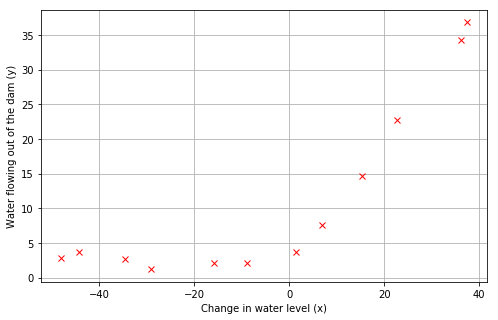

In [108]:
def plotData():
    plt.figure(figsize=(8,5))
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water level (x)')
    plt.plot(X[:,1],y,'rx')
    plt.grid(True)
    
plotData()

1.2 Regularized linear regression cost function

In [17]:
def h(theta, X): # linear hypothesis function
    return np.dot(X, theta)


In [32]:
def computeCost(mytheta, myX, myY, myLambda=0.): # cost function
    """
    theta_start is an n-dimentional vector of initial theta guess
    X is matrix with n-columns and m-rows
    Y is a matrix with m-rows and 1 column
    """
    m = myX.shape[0]
    myh = h(mytheta, myX).reshape((m, 1))
    # cost term
    mycost = float(1./(2*m) * np.dot((myh-myY).T, (myh-myY)))
    # regularized term
    myreg = (float(myLambda)/(2*m)) * float(mytheta[1:].T.dot(mytheta[1:]))
    return mycost + myreg


In [33]:
# Using theta initialized at [1; 1], and lambda = 1, you should expect to 
# see an output of 303.993192
mytheta = np.array([[1.],[1.]])
print (computeCost(mytheta, X, Y, myLambda=1.))

303.9931922202643


1.3 Regularized linear regression gradient

In [34]:
def computeGradient(mytheta, myX, myY, myLambda=0.):
    mytheta = mytheta.reshape((mytheta.shape[0]), 1)
    m = myX.shape[0]
    
    # grad has same shape as myTheta (2x1)
    myh = h(mytheta, myX).reshape((m, 1))
    grad = (1./float(m))*myX.T.dot(h(mytheta, myX)-myY)
    regterm = (float(myLambda)/m)*mytheta
    regterm[0] = 0 # do not regulate bias term
    regterm.reshape((grad.shape[0], 1))
    return grad + regterm
    

In [46]:
# here is a wrapper包装方法 for computeGradient that flattens the output
# this is for the minimization routine最简单的路子 that wants everything flattened
def computeGradientFlattened(mytheta, myX, myY, myLambda=0.):
    """
    flatten()
    1) array 数组 => 将二维数组转变成一维数组
    2) mat 矩阵   => 返回一个二维矩阵，并将原矩阵内的数据合并到一起
    """
    return computeGradient(mytheta, myX, myY, myLambda=0.).flatten()


In [47]:
# Using theta initialized at [1; 1] you should expect to see a
# gradient of [-15.303016; 598.250744] (with lambda=1)
mytheta = np.array([[1.],[1.]])
print (computeGradient(mytheta, X, Y, 1.))


[[-15.30301567]
 [598.25074417]]


1.4 Fitting linear regression

In [48]:
def optimizeTheta(myTheta_initial, myX, myY, myLambda=0., print_out=True):
    fit_theta = scipy.optimize.fmin_cg(computeCost, x0=myTheta_initial, \
                                       fprime=computeGradientFlattened, \
                                       args=(myX, myY, myLambda), \
                                       disp=print_out, \
                                       epsilon=1.49e-12, \
                                       maxiter=1000)
    fit_theta = fit_theta.reshape((myTheta_initial.shape[0], 1))
    return fit_theta


In [49]:
mytheta = np.array([[1.], [1.]])
fit_theta = optimizeTheta(mytheta, X, Y, 0.)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


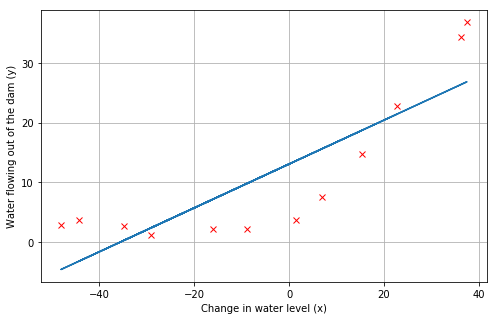

In [50]:
plotData()
plt.plot(X[:,1], h(fit_theta, X).flatten())

2 Bias-variance

2.1 Learning curves

In [62]:
def plotLearningCurve():
    """
    Loop over first training point, then first 2 training points, then first 3 ...
    and use each training-set-subset to find trained parameters.
    
    With those parameters, compute the cost on that subset(Jtrain)
    remembering that for Jtrainm, lambda = 0 (even if you are using regularization)
    
    Then, use the trained parameters to compute Jval on the entire validation set
    again forcing lambda = 0 even if using regularization.
    
    Store the computed error, error_train and error_val and plot them.
    """
    initial_theta = np.array([[1.], [1.]])
    mym, error_train, error_val = [], [], []
    
    # 取部分数据作为training set
    for x in range(1, 13, 1):
        # X[:x, :] 第0行 - 第x-1行，所有列数据
        train_subset = X[:x, :] # => x
        y_subset = Y[:x] # => y
        mym.append(y_subset.shape[0])
        fit_theta = optimizeTheta(initial_theta, train_subset, y_subset, myLambda=0., print_out=False)
        # 根据现有的theta，以及training set数据，获得cost
        error_train.append(computeCost(fit_theta, train_subset, y_subset, myLambda=0.))
        # 根据现有的theta，以及cross validation数据，获得cost
        # Xval, Yval => cross validation set values
        error_val.append(computeCost(fit_theta, Xval, Yval, myLambda=0.))
    
    # 绘图
    plt.figure(figsize=(8,5))
    plt.plot(mym, error_train, label='Train')
    plt.plot(mym, error_val, label='Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(True)
    

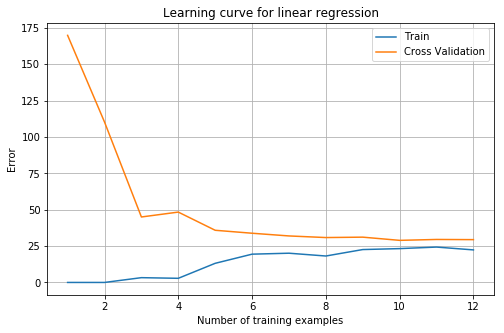

In [63]:
#"You can observe that both the train error and cross validation error are high
# when the number of training examples is increased. This reflects a high bias 
# problem in the model – the linear regression model is too simple and is unable 
# to fit our dataset well."
plotLearningCurve()

# 获得一个high bias -> underfit
# 可以通过增加feature，减少lambda改善


3 Polynomial regression

In [71]:
def genPolyFeatures(myX, p):
    """
    Function takes in the X matrix (with bias term already included as the first column)
    and returns an X matrix with "p" additional columns.
    
    The first additional column will be the 2nd column (first non-bias column) squared,
    the next additional column will be the 2nd column cubed立方, etc.
    """
    # hθ (x) = θ0 + θ1 ∗ (waterLevel) + θ2 ∗ (waterLevel)2 + · · · + θp ∗ (waterLevel)p
    #        = θ0 +θ1x1 +θ2x2 +...+θpxp.
    newX = myX.copy()
    for i in range(p):
        dim = i+2
        newX = np.insert(newX, newX.shape[1], np.power(newX[:, 1], dim), axis=1)
    return newX
    

In [82]:
def featureNormalize(myX):
    """
    Takes as input the X array (with bias "1" first column), does
    feature normalizing on the columns (subtract mean减去平均值, divide by standard deviation除以标准差)
    
    Returns the feature-normalizing X, and feature means and stds in a list
    """
    Xnorm = myX.copy()
    stored_feature_means = np.mean(Xnorm, axis=0) # 每列的平均值
    Xnorm[:, 1:] = Xnorm[:, 1:] - stored_feature_means[1:]
    
    stored_feature_stds = np.std(Xnorm, axis=0, ddof=1) # 每列的平均值
    Xnorm[:, 1:] = Xnorm[:, 1:] / stored_feature_stds[1:]
    
    return Xnorm, stored_feature_means, stored_feature_stds
    
    

3.1 Learning Polynomial Regression

In [96]:
#Generate an X matrix with terms up through x^8
#(7 additional columns to the X matrix)

###############################################################
# My d=8 plot doesn't match the homework pdf, due to differences
# between scipy.optimize.fmin_cg and the octave version
# I see that in subokita's implementation, for fitting he gets the
# same results as I when using scipy.optimize.fmin_cg
# 
# The d=5 plot (up through x^6) shows overfitting clearly, so I'll
# continue using that
###############################################################

global_d = 5 # a polynomial of degree
newX = genPolyFeatures(X, global_d)
newX_norm, stored_means, stored_stds = featureNormalize(newX)
#Find fit parameters starting with 1's as the initial guess
mytheta = np.ones((newX_norm.shape[1],1))
fit_theta = optimizeTheta(mytheta, newX_norm, Y, 0.)

Optimization terminated successfully.
         Current function value: 0.198053
         Iterations: 121
         Function evaluations: 234
         Gradient evaluations: 234


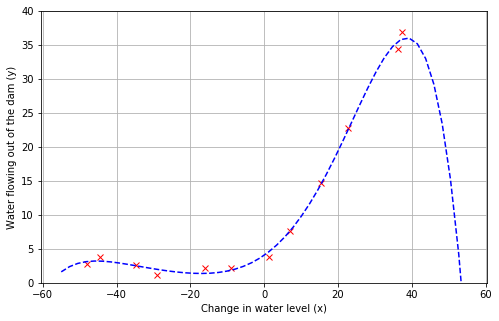

In [98]:
def plotFit(fit_theta, means, stds):
    """
    Function that takes in some learned fit values (on feature-normalized data)
    
    It sets x-points as a linspace (具体看下面Note), constructs an appropriate X matrix,
    un-does previous feature normalization, computes the hypothesis values,
    and plots on top of data
    Note: 
        linspace:
        在matlab的命令窗口输入：X=linspace(1,100)
        将产生从1到100步长为1的数组。类似于在命令窗口中输入：
        X=[1:100]
    """
    n_points_to_plot = 50
    xvals = np.linspace(-55, 55, n_points_to_plot)
    xmat = np.ones((n_points_to_plot, 1))
    
    xmat = np.insert(xmat, xmat.shape[1], xvals.T, axis=1)
    xmat = genPolyFeatures(xmat, len(fit_theta)-2)
    
    # This is undoing feature normalization
    xmat[:, 1:] = xmat[:, 1:] - means[1:]
    xmat[:, 1:] = xmat[:, 1:] / stds[1:]
    plotData()
    plt.plot(xvals,h(fit_theta, xmat),'b--')
    plt.ylim([0,40])

plotFit(fit_theta,stored_means,stored_stds)    
    

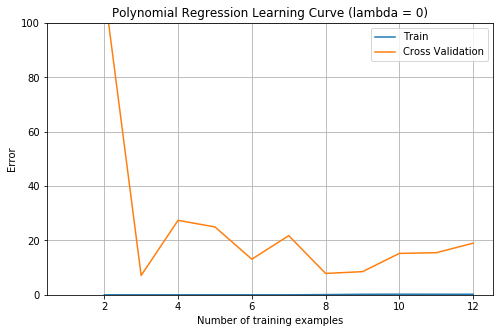

In [78]:
def plotPolyLearningCurve(myLambda=0.):
    
    initial_theta = np.ones((global_d+2, 1))
    mym, error_train, error_val = [], [], []
    myXval, dummy1, dummy2 = featureNormalize(genPolyFeatures(Xval, global_d))
    
    for x in range(1,13,1):
        train_subset = X[:x, :]
        y_subset = Y[:x]
        mym.append(y_subset.shape[0])
        train_subset = genPolyFeatures(train_subset, global_d)
        train_subset, dummy1, dummy2 = featureNormalize(train_subset)
        fit_theta = optimizeTheta(initial_theta, train_subset, y_subset, myLambda=myLambda, print_out=False)
        error_train.append(computeCost(fit_theta, train_subset, y_subset, myLambda=myLambda))
        error_val.append(computeCost(fit_theta, myXval, Yval, myLambda=myLambda))
    
    plt.figure(figsize=(8,5))
    plt.plot(mym, error_train, label='Train')
    plt.plot(mym, error_val, label='Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve (lambda = 0)')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.grid(True)
    
plotPolyLearningCurve() 


3.2 Optional: Adjusting the regularization parameter

         Current function value: 8.042488
         Iterations: 5
         Function evaluations: 69
         Gradient evaluations: 58


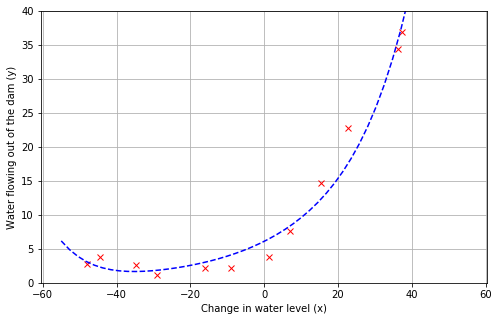

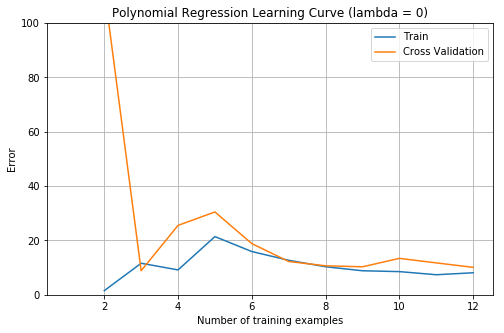

In [100]:
# try lambda = 1
mytheta = np.zeros((newX_norm.shape[1], 1))
fit_theta = optimizeTheta(mytheta, newX_norm, Y, 1)
plotFit(fit_theta, stored_means, stored_stds)
plotPolyLearningCurve(1.)

         Current function value: 131.395246
         Iterations: 0
         Function evaluations: 44
         Gradient evaluations: 32


(-20, 40)

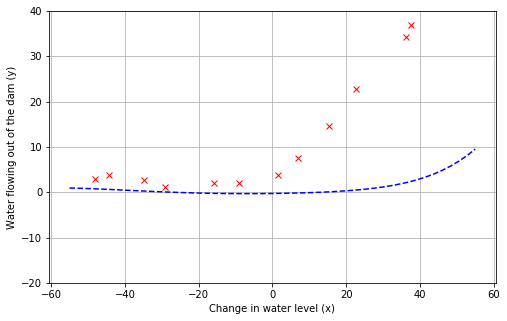

In [101]:
#Try Lambda = 100
#Note after one iteration, the lambda of 100 penalizes the theta params so hard
#that the minimizer loses precision and gives up...
#so the plot below is NOT indicative of a successful fit
mytheta = np.random.rand(newX_norm.shape[1],1)
fit_theta = optimizeTheta(mytheta,newX_norm,Y,100.)
plotFit(fit_theta,stored_means,stored_stds)
plt.ylim(-20,40)


3.3 Selecting  𝜆  using a cross validation set

In [103]:
#lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
lambdas = np.linspace(0,5,20)
errors_train, errors_val = [], []
for mylambda in lambdas:
    newXtrain = genPolyFeatures(X,global_d)
    newXtrain_norm, dummy1, dummy2 = featureNormalize(newXtrain)
    newXval = genPolyFeatures(Xval,global_d)
    newXval_norm, dummy1, dummy2 = featureNormalize(newXval)
    init_theta = np.ones((newX_norm.shape[1],1))
    fit_theta = optimizeTheta(mytheta,newXtrain_norm,y,mylambda,False)
    errors_train.append(computeCost(fit_theta,newXtrain_norm,y,myLambda=mylambda))
    errors_val.append(computeCost(fit_theta,newXval_norm,yval,myLambda=mylambda))

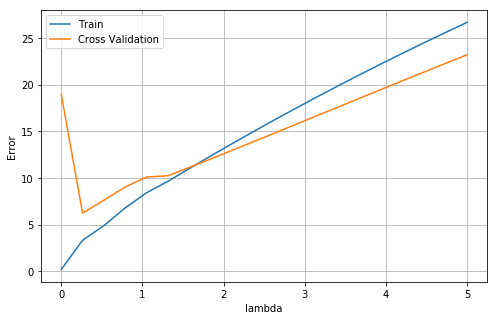

In [104]:
plt.figure(figsize=(8,5))
plt.plot(lambdas,errors_train,label='Train')
plt.plot(lambdas,errors_val,label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)

In [66]:
# test array
a = np.array([[1,2,3], [4,5,6]])
for x in range(1, 3, 1):
    train_subset = a[:x, 1:]
    print (x, train_subset)
print (np.std(a, axis=0), np.std(a, axis=0, ddof=1))     

1 [[2 3]]
2 [[2 3]
 [5 6]]
[1.5 1.5 1.5] [2.12132034 2.12132034 2.12132034]
